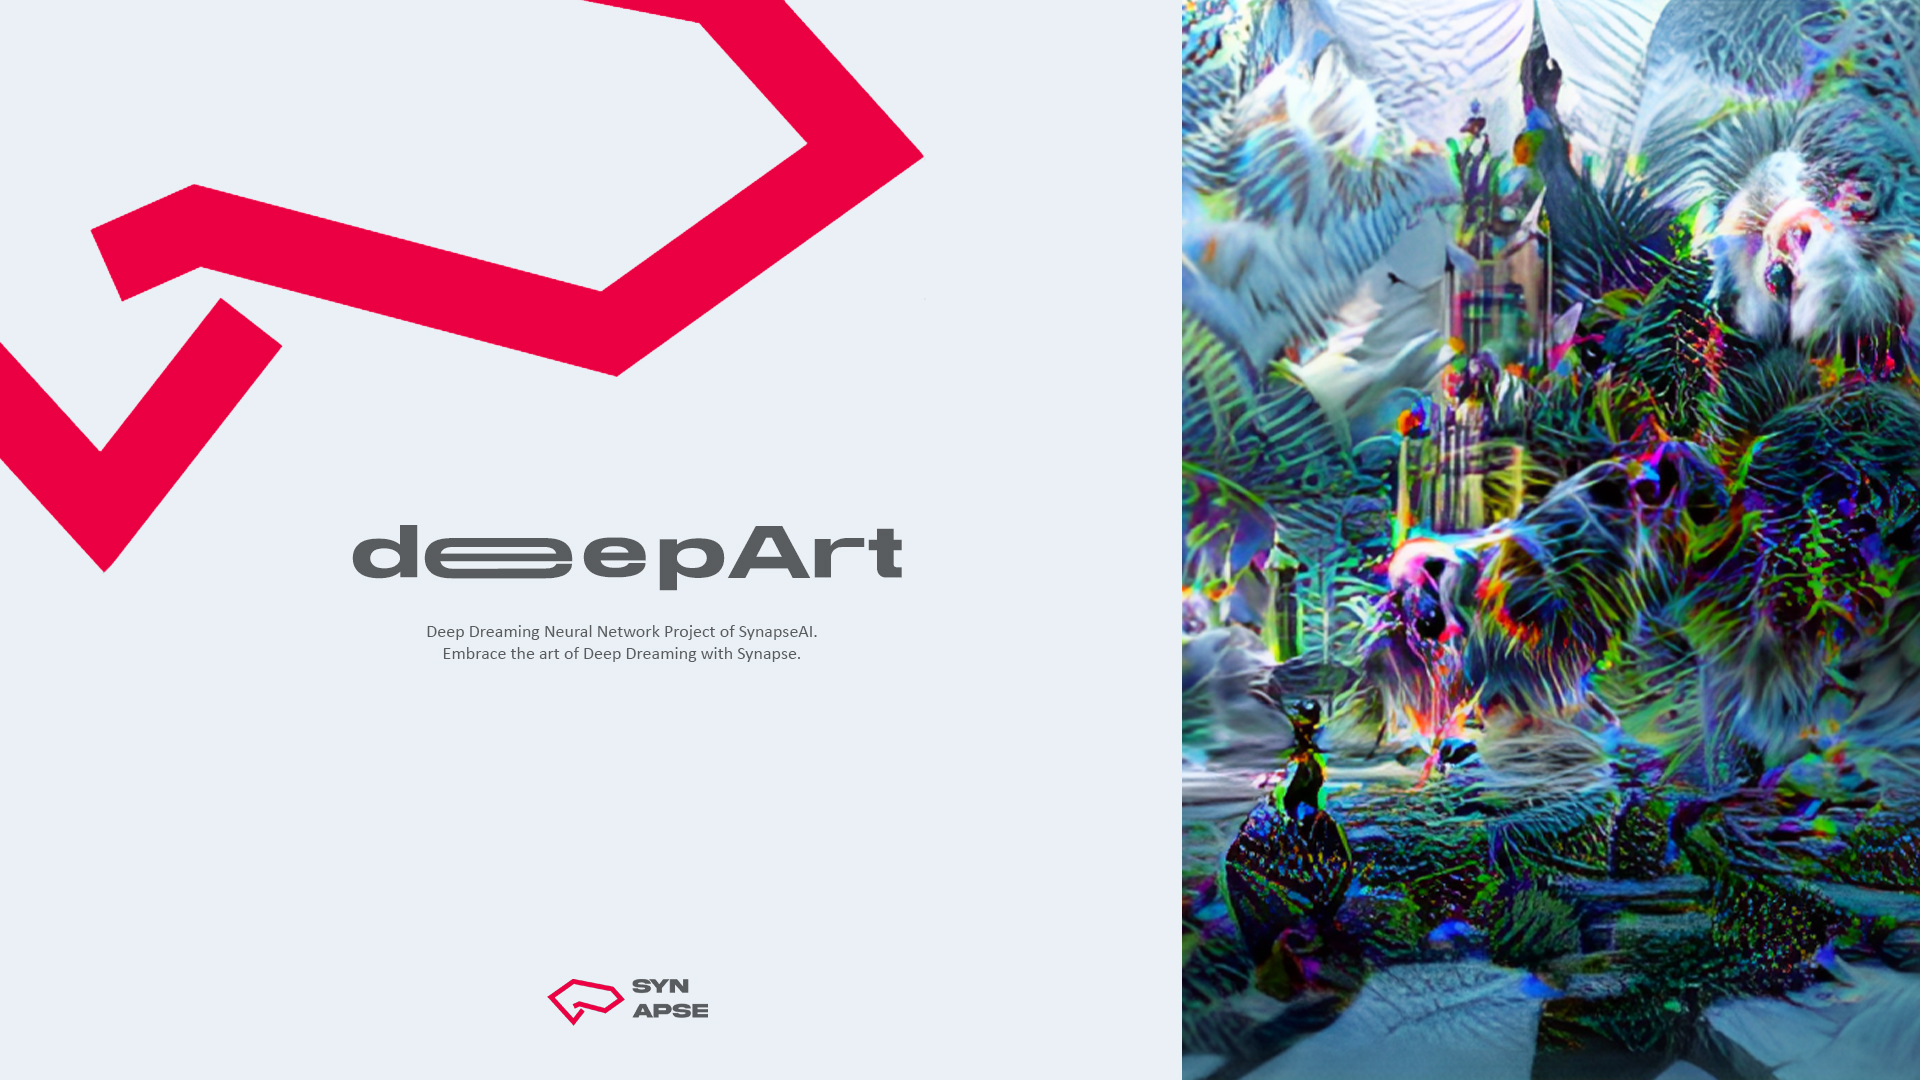

In [1]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [5]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [71]:
layer_name = 'mixed4'  # or 'mixed5'
layer = model.get_layer(layer_name).output


In [72]:
dream_model = tf.keras.Model(model.input, layer)

In [74]:
def calc_loss(image, model):
    # Forward pass through the model
    img_batch = tf.expand_dims(image, axis=0)
    layer_activations = model(img_batch)

    # Calculate the mean of the activations
    loss = tf.reduce_mean(layer_activations)
    return loss

In [73]:
def deepdream_step(image, model, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calc_loss(image, model)
    # Calculate the gradients of the loss with respect to the image pixels
    gradients = tape.gradient(loss, image)
    # Normalize the gradients
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    # Update the image pixels using the gradients and the learning rate
    image += gradients * learning_rate
    image = tf.clip_by_value(image, -1, 1)
    return loss, image

In [75]:
def deepdream(image, model, iterations=50, learning_rate=0.01):
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    image = tf.convert_to_tensor(image)

    for i in range(iterations):
        loss, image = deepdream_step(image, model, learning_rate)

        if i % 10 == 0:
            print("Iteration {}, Loss: {}".format(i, loss))

    # Convert the tensor image to a NumPy array
    image = tf.squeeze(image)
    image = image.numpy()
    image = image / 2.0 + 0.5
    image = np.clip(image, 0, 1)

    return image

In [100]:
input_image = PIL.Image.open('castle.jpg')
input_image = input_image.resize((224, 224))
input_image = np.array(input_image)

In [101]:
dream_image = deepdream(input_image, dream_model, iterations=50, learning_rate=0.04)

Iteration 0, Loss: 0.22156241536140442
Iteration 10, Loss: 0.5277159214019775
Iteration 20, Loss: 0.6934375166893005
Iteration 30, Loss: 0.7965872287750244
Iteration 40, Loss: 0.8832715153694153


In [102]:
output_image = PIL.Image.fromarray(np.uint8(dream_image * 255))
output_image = output_image.resize((input_image.shape[1], input_image.shape[0]))  # Resize using shape

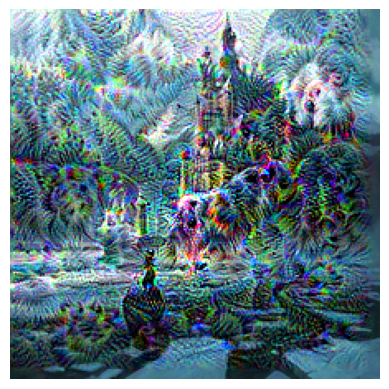

In [103]:
plt.imshow(output_image)
plt.axis('off')
plt.show()